In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import shutil
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import rotate

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D
from keras import optimizers
from keras.models import Model

import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13126101095463036637
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2654994432
locality {
  bus_id: 1
}
incarnation: 8259136067435965565
physical_device_desc: "device: 0, name: GeForce GTX 780, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


In [4]:
path = "/mnt/ML-drive/scanner-ml/Artem/share/Valerio/"
class_names = ['C100keV','TestSample']
n_pols = 8

In [5]:
def load_images(path, name_dir='TestSample', n_pols=8):
    
    img_ind = []
    path = path+name_dir+"/crops/"
    img_names = os.listdir(path)
    for name in img_names:
        img_ind.append(re.split('[_.]',name))
    img_ind = pd.DataFrame(np.array(img_ind),columns=['ViewID','gr','GrainID','pol','Polarization','cl','ClusterID','csv'])
    img_ind = img_ind.drop(['csv'],axis=1).sort_values(['ViewID','GrainID','Polarization'])
    for view in np.unique(img_ind['ViewID']):
        view_imgs = img_ind[ img_ind['ViewID']==view ]
        for grain in np.unique(view_imgs['GrainID']):
            grain_imgs = view_imgs[ view_imgs['GrainID']==grain ]
            if grain_imgs.shape[0]!=8:
                img_ind = img_ind.drop(grain_imgs.index)
    img_names = []
    for name in img_ind.values:
        img_names.append('_'.join(name)+'.csv')
    
    i=0
    im_array = []
    for name in img_names:
        if i==0 : tmp_im = []
        tmp_im.append(pd.read_csv(path+name, header=None).drop(31, axis=1).values)
        i+=1
        if i==n_pols:
            im_array.append(np.array(tmp_im).T)
            i=0
    return np.array(im_array)

In [6]:
%%time
X_sign = load_images(path, 'C100keV')
y_sign = np.ones((X_sign.shape[0],1))
X_noise = load_images(path, 'TestSample')
y_noise = np.zeros((X_noise.shape[0],1))

X = np.vstack((X_sign, X_noise))
y = np.vstack((y_sign, y_noise))

CPU times: user 9min 13s, sys: 13.8 s, total: 9min 27s
Wall time: 10min 3s


# VGG 3D with rotations

(31, 31, 8)

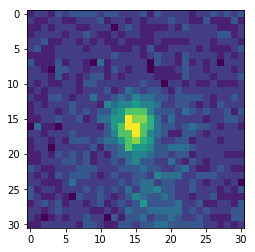

In [7]:
plt.imshow((X[1464].T)[0])
X[1464].shape

(1, 31, 31, 8)

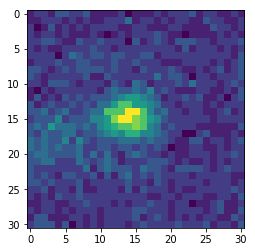

In [8]:
copa = rotate(X[1464], 90, mode='reflect', order=3, preserve_range=True)
plt.imshow((copa.T)[0])
np.array([copa]).shape

In [25]:
angles = np.append((np.random.rand(6)-0.5)*180, 0)
angles

array([ 22.70450706,  48.87868273,  34.23015659, -68.26740254,
        57.35423412, -47.51089747,   0.        ])

In [26]:
#data with rotations
timeka = datetime.now()

X_rot = []
y_rot = []
y_rot_angle = []

for angle in angles:
    y_rot_angle = np.append(y_rot_angle, np.ones(X.shape[0])*angle)
y_rot_angle = y_rot_angle.reshape((y_rot_angle.shape[0],1))
    
for angle in angles:
    for i in np.arange(X.shape[0]):
        image = X[i]
        if angle != 0: rot_im = rotate(image, angle, mode='reflect', order=3, preserve_range=True)
        else: rot_im = image
        X_rot.append(rot_im)
        y_rot.append(y[i,0])
        if not(i%5000): print('time ', datetime.now()-timeka ,'\tfor ',i,' images   \tfor angle ',angle)

time  0:00:00.003010 	for  0  images   	for angle  22.704507059464312
time  0:00:06.427549 	for  5000  images   	for angle  22.704507059464312
time  0:00:12.766536 	for  10000  images   	for angle  22.704507059464312
time  0:00:19.127017 	for  15000  images   	for angle  22.704507059464312
time  0:00:25.554611 	for  20000  images   	for angle  22.704507059464312
time  0:00:29.651952 	for  0  images   	for angle  48.8786827256028
time  0:00:36.117815 	for  5000  images   	for angle  48.8786827256028
time  0:00:42.574621 	for  10000  images   	for angle  48.8786827256028
time  0:00:49.031777 	for  15000  images   	for angle  48.8786827256028
time  0:00:55.492084 	for  20000  images   	for angle  48.8786827256028
time  0:00:59.442130 	for  0  images   	for angle  34.23015658915349
time  0:01:05.728777 	for  5000  images   	for angle  34.23015658915349
time  0:01:12.155420 	for  10000  images   	for angle  34.23015658915349
time  0:01:18.584296 	for  15000  images   	for angle  34.23015658

In [27]:
%%time
X_rot = np.array(X_rot).reshape((y_rot_angle.shape[0],*X.shape[1:],1))
y_rot = np.array([y_rot]).T

CPU times: user 1.46 s, sys: 2.16 s, total: 3.63 s
Wall time: 3.59 s


In [28]:
%%time

X_rot_train, X_rot_test, Y_rot_train, Y_rot_test, Y_rot_angle_train, Y_rot_angle_test = train_test_split(X_rot, y_rot, y_rot_angle, test_size=0.15, stratify=y_rot)

print ("X_3d_rot_train shape: " + str(X_rot_train.shape))
print ("Y_rot_train shape: " + str(Y_rot_train.shape))
print ("X_3d_rot_test shape: " + str(X_rot_test.shape))
print ("Y_rot_test shape: " + str(Y_rot_test.shape))

X_3d_rot_train shape: (137926, 31, 31, 8, 1)
Y_rot_train shape: (137926, 1)
X_3d_rot_test shape: (24341, 31, 31, 8, 1)
Y_rot_test shape: (24341, 1)
CPU times: user 2.52 s, sys: 1.83 s, total: 4.36 s
Wall time: 4.31 s


In [29]:
vgg_rot_hist = []
vgg_rot_hist_DXII = []

In [30]:
def DDD_VGG_rot_model(input_shape=(31,31,8,1), classes=2):
    
    
    X_input = Input(input_shape)

    X = Conv3D(64, 3, padding='same', activation='relu', name='conv1_1')(X_input)
    X = Conv3D(64, 3, padding='same', name='conv1_2')(X)
    #X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = Conv3D(128, 3, padding='same', name='conv2')(X)
    #X = BatchNormalization(name='batch2')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(name='pool2')(X)
    print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop_middle')(X)
    
    X = Conv3D(256, 3, padding='same', name='conv3')(X)
    #X = BatchNormalization(name='batch3')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(name='pool3')(X)
    print('conv3\t',X.get_shape())
    
    X = Conv3D(512, 3, padding='same', name='conv4')(X)
    #X = BatchNormalization(name='batch4')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(padding='same', name='pool4')(X)
    print('conv4\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop')(X)
    
    X = Flatten()(X)
    X_class = Dense(1, activation='sigmoid', name='class')(X)
    X_angle = Dense(1, name='angle')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = [X_class,X_angle], name='3D_VGG_rot_model')
    return model

In [31]:
adamka = optimizers.Adam(lr=1e-3, decay=1e-5)
ddd_vgg_rot_model = DDD_VGG_rot_model(input_shape=(31,31,8,1))
ddd_vgg_rot_model.compile(optimizer=adamka, loss=['binary_crossentropy','mean_squared_error'], loss_weights=[10.,0.01], metrics={'class':'accuracy','angle':'mae'})

conv1	 (?, 15, 15, 4, 64)
conv2	 (?, 7, 7, 2, 128)
conv3	 (?, 3, 3, 1, 256)
conv4	 (?, 2, 2, 1, 512)


In [32]:
vgg_rot_hist_DXII.append(ddd_vgg_rot_model.fit(X_rot_train, [Y_rot_train, Y_rot_angle_train], epochs = 100, batch_size = 128, validation_split=0.15, verbose=1))

Train on 117237 samples, validate on 20689 samples
Epoch 1/100
117237/117237 [==============================] - 1020s 9ms/step - loss: 20.9093 - class_loss: 0.5732 - angle_loss: 1517.7728 - class_acc: 0.7169 - angle_mean_absolute_error: 32.1113 - val_loss: 8.3595 - val_class_loss: 0.4465 - val_angle_loss: 389.4593 - val_class_acc: 0.8030 - val_angle_mean_absolute_error: 14.6957
Epoch 2/100
117237/117237 [==============================] - 1007s 9ms/step - loss: 8.8012 - class_loss: 0.4483 - angle_loss: 431.7872 - class_acc: 0.7968 - angle_mean_absolute_error: 15.3415 - val_loss: 6.2398 - val_class_loss: 0.3778 - val_angle_loss: 246.2304 - val_class_acc: 0.8369 - val_angle_mean_absolute_error: 11.2083
Epoch 3/100
117237/117237 [==============================] - 1007s 9ms/step - loss: 6.8487 - class_loss: 0.3758 - angle_loss: 309.0522 - class_acc: 0.8361 - angle_mean_absolute_error: 12.6427 - val_loss: 4.4955 - val_class_loss: 0.2662 - val_angle_loss: 183.3401 - val_class_acc: 0.8864 - va

Epoch 26/100
117237/117237 [==============================] - 1008s 9ms/step - loss: 2.6945 - class_loss: 0.1454 - angle_loss: 124.0870 - class_acc: 0.9427 - angle_mean_absolute_error: 7.9347 - val_loss: 2.4840 - val_class_loss: 0.1500 - val_angle_loss: 98.3981 - val_class_acc: 0.9404 - val_angle_mean_absolute_error: 6.4434
Epoch 27/100
117237/117237 [==============================] - 1008s 9ms/step - loss: 2.7323 - class_loss: 0.1451 - angle_loss: 128.1104 - class_acc: 0.9424 - angle_mean_absolute_error: 8.0403 - val_loss: 2.1642 - val_class_loss: 0.1260 - val_angle_loss: 90.4647 - val_class_acc: 0.9525 - val_angle_mean_absolute_error: 6.4712
Epoch 28/100
117237/117237 [==============================] - 1008s 9ms/step - loss: 2.6922 - class_loss: 0.1460 - angle_loss: 123.1840 - class_acc: 0.9418 - angle_mean_absolute_error: 7.9202 - val_loss: 2.1322 - val_class_loss: 0.1310 - val_angle_loss: 82.2092 - val_class_acc: 0.9489 - val_angle_mean_absolute_error: 5.9397
Epoch 29/100
117237/11

117237/117237 [==============================] - 1008s 9ms/step - loss: 2.1460 - class_loss: 0.1118 - angle_loss: 102.7551 - class_acc: 0.9556 - angle_mean_absolute_error: 7.2771 - val_loss: 2.4081 - val_class_loss: 0.1617 - val_angle_loss: 79.1526 - val_class_acc: 0.9381 - val_angle_mean_absolute_error: 6.2395
Epoch 52/100
117237/117237 [==============================] - 1008s 9ms/step - loss: 2.1380 - class_loss: 0.1110 - angle_loss: 102.8298 - class_acc: 0.9562 - angle_mean_absolute_error: 7.2678 - val_loss: 1.9500 - val_class_loss: 0.1208 - val_angle_loss: 74.1879 - val_class_acc: 0.9513 - val_angle_mean_absolute_error: 5.7995
Epoch 53/100
117237/117237 [==============================] - 1008s 9ms/step - loss: 2.0520 - class_loss: 0.1073 - angle_loss: 97.8932 - class_acc: 0.9581 - angle_mean_absolute_error: 7.1106 - val_loss: 2.2610 - val_class_loss: 0.1583 - val_angle_loss: 67.7906 - val_class_acc: 0.9432 - val_angle_mean_absolute_error: 5.4380
Epoch 54/100
117237/117237 [========

117237/117237 [==============================] - 1007s 9ms/step - loss: 1.7471 - class_loss: 0.0854 - angle_loss: 89.3110 - class_acc: 0.9665 - angle_mean_absolute_error: 6.8105 - val_loss: 1.6229 - val_class_loss: 0.0954 - val_angle_loss: 66.9229 - val_class_acc: 0.9642 - val_angle_mean_absolute_error: 5.4074
Epoch 77/100
117237/117237 [==============================] - 1008s 9ms/step - loss: 1.7621 - class_loss: 0.0862 - angle_loss: 89.9794 - class_acc: 0.9665 - angle_mean_absolute_error: 6.8321 - val_loss: 1.6013 - val_class_loss: 0.0925 - val_angle_loss: 67.6402 - val_class_acc: 0.9653 - val_angle_mean_absolute_error: 5.3867
Epoch 78/100
117237/117237 [==============================] - 1009s 9ms/step - loss: 1.7039 - class_loss: 0.0820 - angle_loss: 88.4230 - class_acc: 0.9671 - angle_mean_absolute_error: 6.7771 - val_loss: 1.5349 - val_class_loss: 0.0941 - val_angle_loss: 59.3593 - val_class_acc: 0.9661 - val_angle_mean_absolute_error: 5.0700
Epoch 79/100
117237/117237 [==========

In [33]:
preds = ddd_vgg_rot_model.evaluate(X_rot_test, [Y_rot_test, Y_rot_angle_test])

24341/24341 [==============================] - 76s 3ms/step


In [34]:
print ("Loss = " + str(np.around(preds[0],decimals=2)))
print ("Test Accuracy = " + str(np.around(preds[3],decimals=3)))
print ('Test Angle MAE = ',np.around(preds[4],decimals=2))

Loss = 1.81
Test Accuracy = 0.958
Test Angle MAE =  5.41


/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


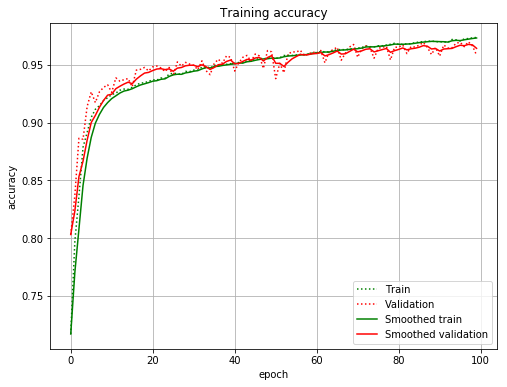

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


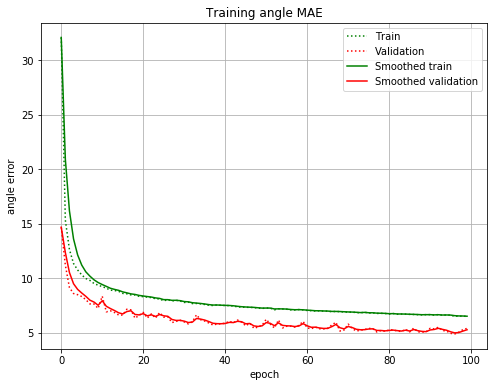

In [35]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(vgg_rot_hist_DXII[-1].history['class_acc'], "g:", label='Train')
plt.plot(vgg_rot_hist_DXII[-1].history['val_class_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['class_acc']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['val_class_acc']),span=5), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.savefig('acc_rot512.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training angle MAE')
plt.plot(vgg_rot_hist_DXII[-1].history['angle_mean_absolute_error'], "g:", label='Train')
plt.plot(vgg_rot_hist_DXII[-1].history['val_angle_mean_absolute_error'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['angle_mean_absolute_error']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['val_angle_mean_absolute_error']),span=3), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('angle error')
plt.grid()
plt.legend()
plt.savefig('angle_rot512.pdf')
plt.show()

In [36]:
with open('angles.txt','w') as file:
    file.write('\t'.join(map(str,np.around(angles,decimals=2))))

In [41]:
def CNN_model(input_shape=(31,31,8), classes=2):
    
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1,1))(X_input)
    X = Conv2D(64, 3, name='conv1')(X)
    #X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = Flatten()(X)
    X_class = Dense(1, activation='sigmoid', name='class')(X)
    X_angle = Dense(1, name='angle')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = [X_class, X_angle], name='Simple_2D_rot_model')
    return model

In [45]:
cnn_model = CNN_model(input_shape=(31,31,8))
nadamka = keras.optimizers.Nadam(lr=1e-4)
cnn_model.compile(optimizer=nadamka, loss=['binary_crossentropy','mean_squared_error'], loss_weights=[1.,0.01], metrics={'class':'accuracy','angle':'mae'})
hist_dd = cnn_model.fit(np.squeeze(X_rot_train), [Y_rot_train, Y_rot_angle_train], epochs = 400, batch_size = 256, validation_split=0.15)

conv1	 (?, 15, 15, 64)
Train on 117237 samples, validate on 20689 samples
Epoch 1/400
117237/117237 [==============================] - 16s 135us/step - loss: 20.1896 - class_loss: 0.7686 - angle_loss: 1942.1023 - class_acc: 0.6448 - angle_mean_absolute_error: 38.2724 - val_loss: 19.4508 - val_class_loss: 0.6886 - val_angle_loss: 1876.2219 - val_class_acc: 0.6898 - val_angle_mean_absolute_error: 37.3450
Epoch 2/400
117237/117237 [==============================] - 16s 133us/step - loss: 18.3100 - class_loss: 0.7721 - angle_loss: 1753.7851 - class_acc: 0.6528 - angle_mean_absolute_error: 36.1310 - val_loss: 17.4767 - val_class_loss: 1.0985 - val_angle_loss: 1637.8267 - val_class_acc: 0.6899 - val_angle_mean_absolute_error: 35.2398
Epoch 3/400
117237/117237 [==============================] - 15s 132us/step - loss: 15.8396 - class_loss: 0.8178 - angle_loss: 1502.1840 - class_acc: 0.6528 - angle_mean_absolute_error: 33.0101 - val_loss: 14.5761 - val_class_loss: 0.7413 - val_angle_loss: 1383.

Epoch 26/400
117237/117237 [==============================] - 15s 131us/step - loss: 5.5369 - class_loss: 0.1983 - angle_loss: 533.8591 - class_acc: 0.9212 - angle_mean_absolute_error: 17.6118 - val_loss: 5.5262 - val_class_loss: 0.1767 - val_angle_loss: 534.9530 - val_class_acc: 0.9325 - val_angle_mean_absolute_error: 17.5654
Epoch 27/400
117237/117237 [==============================] - 15s 131us/step - loss: 5.4560 - class_loss: 0.1970 - angle_loss: 525.9045 - class_acc: 0.9212 - angle_mean_absolute_error: 17.4899 - val_loss: 5.4572 - val_class_loss: 0.1845 - val_angle_loss: 527.2663 - val_class_acc: 0.9299 - val_angle_mean_absolute_error: 17.6183
Epoch 28/400
117237/117237 [==============================] - 15s 132us/step - loss: 5.3804 - class_loss: 0.1933 - angle_loss: 518.7134 - class_acc: 0.9234 - angle_mean_absolute_error: 17.3684 - val_loss: 5.6021 - val_class_loss: 0.4151 - val_angle_loss: 518.7019 - val_class_acc: 0.8320 - val_angle_mean_absolute_error: 17.3467
Epoch 29/400


Epoch 51/400
117237/117237 [==============================] - 15s 132us/step - loss: 4.1683 - class_loss: 0.1566 - angle_loss: 401.1695 - class_acc: 0.9387 - angle_mean_absolute_error: 15.3720 - val_loss: 4.2805 - val_class_loss: 0.1603 - val_angle_loss: 412.0275 - val_class_acc: 0.9393 - val_angle_mean_absolute_error: 15.5108
Epoch 52/400
117237/117237 [==============================] - 15s 132us/step - loss: 4.1350 - class_loss: 0.1554 - angle_loss: 397.9615 - class_acc: 0.9387 - angle_mean_absolute_error: 15.3046 - val_loss: 4.2751 - val_class_loss: 0.1737 - val_angle_loss: 410.1426 - val_class_acc: 0.9310 - val_angle_mean_absolute_error: 15.4561
Epoch 53/400
117237/117237 [==============================] - 16s 132us/step - loss: 4.1006 - class_loss: 0.1547 - angle_loss: 394.5897 - class_acc: 0.9394 - angle_mean_absolute_error: 15.2450 - val_loss: 4.2159 - val_class_loss: 0.1555 - val_angle_loss: 406.0374 - val_class_acc: 0.9406 - val_angle_mean_absolute_error: 15.3561
Epoch 54/400


Epoch 76/400
117237/117237 [==============================] - 15s 132us/step - loss: 3.5425 - class_loss: 0.1433 - angle_loss: 339.9186 - class_acc: 0.9435 - angle_mean_absolute_error: 14.1846 - val_loss: 3.7164 - val_class_loss: 0.1511 - val_angle_loss: 356.5282 - val_class_acc: 0.9428 - val_angle_mean_absolute_error: 14.3727
Epoch 77/400
117237/117237 [==============================] - 15s 132us/step - loss: 3.5236 - class_loss: 0.1407 - angle_loss: 338.2895 - class_acc: 0.9448 - angle_mean_absolute_error: 14.1507 - val_loss: 3.7379 - val_class_loss: 0.1519 - val_angle_loss: 358.5969 - val_class_acc: 0.9420 - val_angle_mean_absolute_error: 14.4970
Epoch 78/400
117237/117237 [==============================] - 16s 132us/step - loss: 3.5120 - class_loss: 0.1405 - angle_loss: 337.1490 - class_acc: 0.9450 - angle_mean_absolute_error: 14.1233 - val_loss: 3.6988 - val_class_loss: 0.1621 - val_angle_loss: 353.6698 - val_class_acc: 0.9383 - val_angle_mean_absolute_error: 14.3387
Epoch 79/400


Epoch 101/400
117237/117237 [==============================] - 15s 132us/step - loss: 3.2022 - class_loss: 0.1294 - angle_loss: 307.2813 - class_acc: 0.9495 - angle_mean_absolute_error: 13.5028 - val_loss: 3.3618 - val_class_loss: 0.1496 - val_angle_loss: 321.2202 - val_class_acc: 0.9422 - val_angle_mean_absolute_error: 13.6957
Epoch 102/400
117237/117237 [==============================] - 15s 132us/step - loss: 3.1925 - class_loss: 0.1296 - angle_loss: 306.2866 - class_acc: 0.9493 - angle_mean_absolute_error: 13.4835 - val_loss: 3.3656 - val_class_loss: 0.1470 - val_angle_loss: 321.8660 - val_class_acc: 0.9438 - val_angle_mean_absolute_error: 13.6729
Epoch 103/400
117237/117237 [==============================] - 16s 132us/step - loss: 3.1808 - class_loss: 0.1291 - angle_loss: 305.1673 - class_acc: 0.9497 - angle_mean_absolute_error: 13.4517 - val_loss: 3.3829 - val_class_loss: 0.1623 - val_angle_loss: 322.0560 - val_class_acc: 0.9372 - val_angle_mean_absolute_error: 13.6829
Epoch 104/

Epoch 126/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.9569 - class_loss: 0.1207 - angle_loss: 283.6226 - class_acc: 0.9528 - angle_mean_absolute_error: 12.9885 - val_loss: 3.1489 - val_class_loss: 0.1609 - val_angle_loss: 298.7967 - val_class_acc: 0.9389 - val_angle_mean_absolute_error: 13.2033
Epoch 127/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.9509 - class_loss: 0.1233 - angle_loss: 282.7628 - class_acc: 0.9519 - angle_mean_absolute_error: 12.9805 - val_loss: 3.1626 - val_class_loss: 0.1455 - val_angle_loss: 301.7100 - val_class_acc: 0.9447 - val_angle_mean_absolute_error: 13.3459
Epoch 128/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.9420 - class_loss: 0.1230 - angle_loss: 281.9029 - class_acc: 0.9522 - angle_mean_absolute_error: 12.9572 - val_loss: 3.2687 - val_class_loss: 0.1494 - val_angle_loss: 311.9322 - val_class_acc: 0.9436 - val_angle_mean_absolute_error: 13.6303
Epoch 129/

Epoch 151/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.7636 - class_loss: 0.1142 - angle_loss: 264.9365 - class_acc: 0.9559 - angle_mean_absolute_error: 12.5741 - val_loss: 2.9827 - val_class_loss: 0.1651 - val_angle_loss: 281.7567 - val_class_acc: 0.9360 - val_angle_mean_absolute_error: 12.8740
Epoch 152/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.7605 - class_loss: 0.1188 - angle_loss: 264.1674 - class_acc: 0.9533 - angle_mean_absolute_error: 12.5482 - val_loss: 2.9626 - val_class_loss: 0.1501 - val_angle_loss: 281.2484 - val_class_acc: 0.9437 - val_angle_mean_absolute_error: 12.8526
Epoch 153/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.7508 - class_loss: 0.1169 - angle_loss: 263.3898 - class_acc: 0.9551 - angle_mean_absolute_error: 12.5354 - val_loss: 2.9854 - val_class_loss: 0.1475 - val_angle_loss: 283.7890 - val_class_acc: 0.9444 - val_angle_mean_absolute_error: 12.8720
Epoch 154/

Epoch 176/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.5992 - class_loss: 0.1101 - angle_loss: 248.9149 - class_acc: 0.9573 - angle_mean_absolute_error: 12.2006 - val_loss: 2.8161 - val_class_loss: 0.1453 - val_angle_loss: 267.0865 - val_class_acc: 0.9449 - val_angle_mean_absolute_error: 12.5529
Epoch 177/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.5943 - class_loss: 0.1117 - angle_loss: 248.2651 - class_acc: 0.9563 - angle_mean_absolute_error: 12.1907 - val_loss: 2.8116 - val_class_loss: 0.1480 - val_angle_loss: 266.3600 - val_class_acc: 0.9436 - val_angle_mean_absolute_error: 12.5135
Epoch 178/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.5863 - class_loss: 0.1110 - angle_loss: 247.5293 - class_acc: 0.9564 - angle_mean_absolute_error: 12.1761 - val_loss: 2.8275 - val_class_loss: 0.1502 - val_angle_loss: 267.7341 - val_class_acc: 0.9442 - val_angle_mean_absolute_error: 12.5845
Epoch 179/

Epoch 201/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.4627 - class_loss: 0.1069 - angle_loss: 235.5836 - class_acc: 0.9578 - angle_mean_absolute_error: 11.8899 - val_loss: 2.7151 - val_class_loss: 0.1457 - val_angle_loss: 256.9398 - val_class_acc: 0.9449 - val_angle_mean_absolute_error: 12.3392
Epoch 202/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.4572 - class_loss: 0.1067 - angle_loss: 235.0566 - class_acc: 0.9585 - angle_mean_absolute_error: 11.8703 - val_loss: 2.7118 - val_class_loss: 0.1443 - val_angle_loss: 256.7500 - val_class_acc: 0.9454 - val_angle_mean_absolute_error: 12.3543
Epoch 203/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.4532 - class_loss: 0.1068 - angle_loss: 234.6406 - class_acc: 0.9585 - angle_mean_absolute_error: 11.8669 - val_loss: 2.6867 - val_class_loss: 0.1464 - val_angle_loss: 254.0271 - val_class_acc: 0.9448 - val_angle_mean_absolute_error: 12.2774
Epoch 204/

Epoch 226/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.3487 - class_loss: 0.1032 - angle_loss: 224.5536 - class_acc: 0.9603 - angle_mean_absolute_error: 11.6196 - val_loss: 2.6267 - val_class_loss: 0.1425 - val_angle_loss: 248.4204 - val_class_acc: 0.9477 - val_angle_mean_absolute_error: 12.1337
Epoch 227/400
117237/117237 [==============================] - 15s 131us/step - loss: 2.3419 - class_loss: 0.1018 - angle_loss: 224.0117 - class_acc: 0.9613 - angle_mean_absolute_error: 11.6027 - val_loss: 2.5695 - val_class_loss: 0.1438 - val_angle_loss: 242.5776 - val_class_acc: 0.9457 - val_angle_mean_absolute_error: 11.9992
Epoch 228/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.3392 - class_loss: 0.1034 - angle_loss: 223.5782 - class_acc: 0.9596 - angle_mean_absolute_error: 11.5944 - val_loss: 2.6016 - val_class_loss: 0.1602 - val_angle_loss: 244.1466 - val_class_acc: 0.9409 - val_angle_mean_absolute_error: 12.0643
Epoch 229/

Epoch 251/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.2496 - class_loss: 0.1003 - angle_loss: 214.9302 - class_acc: 0.9610 - angle_mean_absolute_error: 11.3802 - val_loss: 2.5094 - val_class_loss: 0.1415 - val_angle_loss: 236.7877 - val_class_acc: 0.9475 - val_angle_mean_absolute_error: 11.8463
Epoch 252/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.2433 - class_loss: 0.0999 - angle_loss: 214.3425 - class_acc: 0.9613 - angle_mean_absolute_error: 11.3610 - val_loss: 2.5606 - val_class_loss: 0.1479 - val_angle_loss: 241.2677 - val_class_acc: 0.9461 - val_angle_mean_absolute_error: 11.9835
Epoch 253/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.2395 - class_loss: 0.1000 - angle_loss: 213.9508 - class_acc: 0.9613 - angle_mean_absolute_error: 11.3564 - val_loss: 2.6300 - val_class_loss: 0.1419 - val_angle_loss: 248.8162 - val_class_acc: 0.9474 - val_angle_mean_absolute_error: 12.2678
Epoch 254/

Epoch 276/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.1631 - class_loss: 0.0949 - angle_loss: 206.8168 - class_acc: 0.9636 - angle_mean_absolute_error: 11.1804 - val_loss: 2.4424 - val_class_loss: 0.1453 - val_angle_loss: 229.7099 - val_class_acc: 0.9474 - val_angle_mean_absolute_error: 11.6772
Epoch 277/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.1588 - class_loss: 0.0960 - angle_loss: 206.2728 - class_acc: 0.9630 - angle_mean_absolute_error: 11.1667 - val_loss: 2.4415 - val_class_loss: 0.1475 - val_angle_loss: 229.3962 - val_class_acc: 0.9459 - val_angle_mean_absolute_error: 11.6903
Epoch 278/400
117237/117237 [==============================] - 15s 132us/step - loss: 2.1602 - class_loss: 0.0982 - angle_loss: 206.2059 - class_acc: 0.9616 - angle_mean_absolute_error: 11.1625 - val_loss: 2.4603 - val_class_loss: 0.1426 - val_angle_loss: 231.7762 - val_class_acc: 0.9483 - val_angle_mean_absolute_error: 11.7448
Epoch 279/

Epoch 301/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.0932 - class_loss: 0.0951 - angle_loss: 199.8016 - class_acc: 0.9632 - angle_mean_absolute_error: 10.9965 - val_loss: 2.4180 - val_class_loss: 0.2056 - val_angle_loss: 221.2342 - val_class_acc: 0.9263 - val_angle_mean_absolute_error: 11.4951
Epoch 302/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.0856 - class_loss: 0.0931 - angle_loss: 199.2481 - class_acc: 0.9643 - angle_mean_absolute_error: 10.9815 - val_loss: 2.3594 - val_class_loss: 0.1451 - val_angle_loss: 221.4328 - val_class_acc: 0.9467 - val_angle_mean_absolute_error: 11.5001
Epoch 303/400
117237/117237 [==============================] - 16s 134us/step - loss: 2.0826 - class_loss: 0.0938 - angle_loss: 198.8763 - class_acc: 0.9636 - angle_mean_absolute_error: 10.9718 - val_loss: 2.3813 - val_class_loss: 0.1447 - val_angle_loss: 223.6572 - val_class_acc: 0.9478 - val_angle_mean_absolute_error: 11.5466
Epoch 304/

Epoch 326/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.0287 - class_loss: 0.0914 - angle_loss: 193.7262 - class_acc: 0.9647 - angle_mean_absolute_error: 10.8363 - val_loss: 2.3296 - val_class_loss: 0.1529 - val_angle_loss: 217.6670 - val_class_acc: 0.9451 - val_angle_mean_absolute_error: 11.4141
Epoch 327/400
117237/117237 [==============================] - 16s 132us/step - loss: 2.0231 - class_loss: 0.0905 - angle_loss: 193.2608 - class_acc: 0.9652 - angle_mean_absolute_error: 10.8288 - val_loss: 2.3250 - val_class_loss: 0.1697 - val_angle_loss: 215.5281 - val_class_acc: 0.9390 - val_angle_mean_absolute_error: 11.3534
Epoch 328/400
117237/117237 [==============================] - 16s 133us/step - loss: 2.0208 - class_loss: 0.0924 - angle_loss: 192.8355 - class_acc: 0.9642 - angle_mean_absolute_error: 10.8127 - val_loss: 2.2882 - val_class_loss: 0.1420 - val_angle_loss: 214.6177 - val_class_acc: 0.9486 - val_angle_mean_absolute_error: 11.3355
Epoch 329/

Epoch 351/400
117237/117237 [==============================] - 16s 132us/step - loss: 1.9703 - class_loss: 0.0889 - angle_loss: 188.1374 - class_acc: 0.9664 - angle_mean_absolute_error: 10.6926 - val_loss: 2.2968 - val_class_loss: 0.1542 - val_angle_loss: 214.2590 - val_class_acc: 0.9443 - val_angle_mean_absolute_error: 11.3270
Epoch 352/400
117237/117237 [==============================] - 16s 132us/step - loss: 1.9648 - class_loss: 0.0892 - angle_loss: 187.5563 - class_acc: 0.9656 - angle_mean_absolute_error: 10.6778 - val_loss: 2.2743 - val_class_loss: 0.1459 - val_angle_loss: 212.8450 - val_class_acc: 0.9470 - val_angle_mean_absolute_error: 11.3269
Epoch 353/400
117237/117237 [==============================] - 16s 133us/step - loss: 1.9632 - class_loss: 0.0888 - angle_loss: 187.4446 - class_acc: 0.9654 - angle_mean_absolute_error: 10.6743 - val_loss: 2.3315 - val_class_loss: 0.1645 - val_angle_loss: 216.6993 - val_class_acc: 0.9386 - val_angle_mean_absolute_error: 11.4508
Epoch 354/

Epoch 376/400
117237/117237 [==============================] - 15s 131us/step - loss: 1.9217 - class_loss: 0.0891 - angle_loss: 183.2592 - class_acc: 0.9656 - angle_mean_absolute_error: 10.5583 - val_loss: 2.2542 - val_class_loss: 0.1716 - val_angle_loss: 208.2595 - val_class_acc: 0.9387 - val_angle_mean_absolute_error: 11.1907
Epoch 377/400
117237/117237 [==============================] - 15s 131us/step - loss: 1.9123 - class_loss: 0.0890 - angle_loss: 182.3278 - class_acc: 0.9657 - angle_mean_absolute_error: 10.5265 - val_loss: 2.2124 - val_class_loss: 0.1479 - val_angle_loss: 206.4493 - val_class_acc: 0.9470 - val_angle_mean_absolute_error: 11.1255
Epoch 378/400
117237/117237 [==============================] - 15s 131us/step - loss: 1.9140 - class_loss: 0.0865 - angle_loss: 182.7503 - class_acc: 0.9666 - angle_mean_absolute_error: 10.5436 - val_loss: 2.2249 - val_class_loss: 0.1586 - val_angle_loss: 206.6319 - val_class_acc: 0.9423 - val_angle_mean_absolute_error: 11.1508
Epoch 379/

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


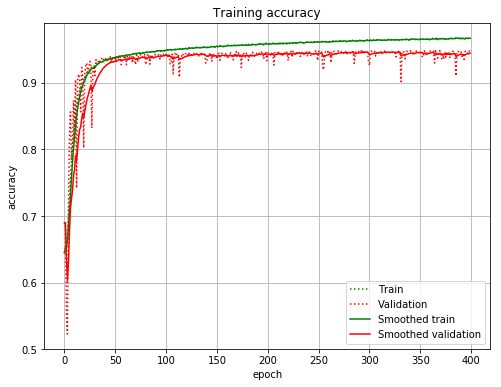

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


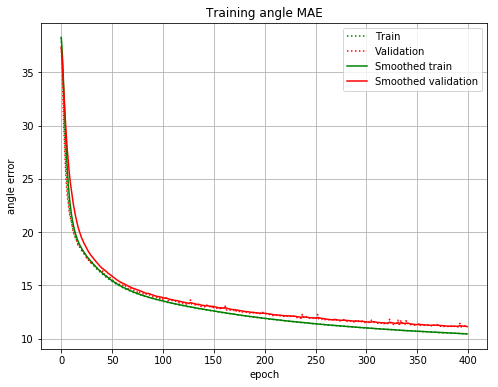

In [48]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(hist_dd.history['class_acc'], "g:", label='Train')
plt.plot(hist_dd.history['val_class_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist_dd.history['class_acc']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist_dd.history['val_class_acc']),span=15), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.savefig('acc_simple_rot.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training angle MAE')
plt.plot(hist_dd.history['angle_mean_absolute_error'], "g:", label='Train')
plt.plot(hist_dd.history['val_angle_mean_absolute_error'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist_dd.history['angle_mean_absolute_error']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist_dd.history['val_angle_mean_absolute_error']),span=10), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('angle error')
plt.grid()
plt.legend()
plt.savefig('angle_simple_rot.pdf')
plt.show()

In [40]:
vgg_rot_hist[-1].history.keys()

dict_keys(['val_loss', 'val_class_loss', 'val_angle_loss', 'val_class_acc', 'val_angle_mean_absolute_error', 'loss', 'class_loss', 'angle_loss', 'class_acc', 'angle_mean_absolute_error'])

In [52]:
acc = []
val_acc = []
mae = []
val_mae = []
for hist in vgg_rot_hist:
    acc = np.append(acc,hist.history['class_acc'])
    val_acc = np.append(val_acc,hist.history['val_class_acc'])
    mae = np.append(mae,hist.history['angle_mean_absolute_error'])
    val_mae = np.append(val_mae,hist.history['val_angle_mean_absolute_error'])

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


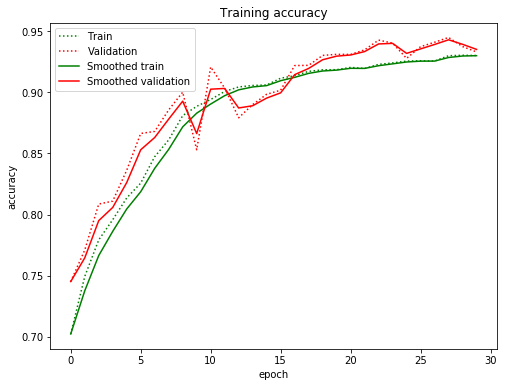

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


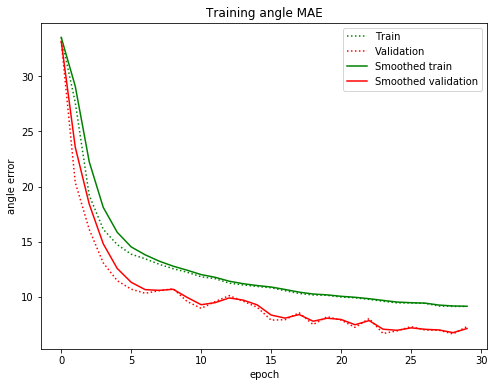

In [58]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(acc, "g:", label='Train')
plt.plot(val_acc, "r:", label='Validation')
plt.plot(pd.ewma(np.array(acc),span=2), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(val_acc),span=2), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc_rot.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training angle MAE')
plt.plot(mae, "g:", label='Train')
plt.plot(val_mae, "r:", label='Validation')
plt.plot(pd.ewma(np.array(mae),span=2), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(val_mae),span=2), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('angle error')
plt.legend()
plt.savefig('angle_rot.pdf')
plt.show()

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


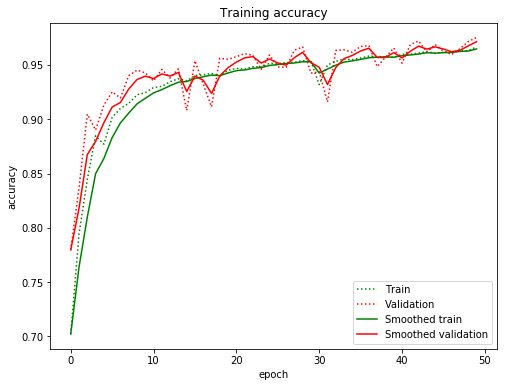

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


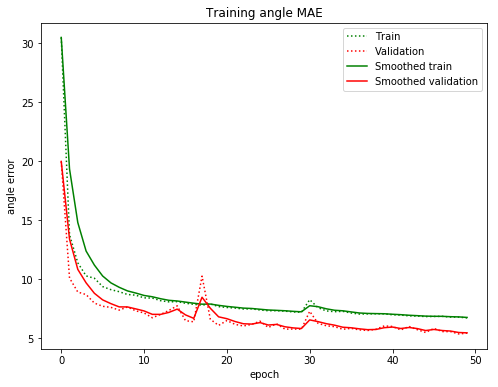

In [19]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(vgg_rot_hist_DXII[-1].history['class_acc'], "g:", label='Train')
plt.plot(vgg_rot_hist_DXII[-1].history['val_class_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['class_acc']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['val_class_acc']),span=3), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc_rot512.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training angle MAE')
plt.plot(vgg_rot_hist_DXII[-1].history['angle_mean_absolute_error'], "g:", label='Train')
plt.plot(vgg_rot_hist_DXII[-1].history['val_angle_mean_absolute_error'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['angle_mean_absolute_error']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['val_angle_mean_absolute_error']),span=3), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('angle error')
plt.legend()
plt.savefig('angle_rot512.pdf')
plt.show()